In [46]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, auc, roc_curve, f1_score, r2_score, confusion_matrix, mean_squared_error, mean_absolute_percentage_error

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from keras import layers
from datetime import datetime
from keras.datasets import mnist
from keras.layers import Dense, LSTM

In [47]:
df = pd.read_excel("Walmart_clusters.xlsx")
class_0 = df[df["cluster_sklearn"] == 0]

In [48]:
class_0.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,yyyy,mm,dd,week_relative,week_absolute,Date,cluster_sklearn
0,3,377219,0,65.065,3.234,216.539,7.567,2010,1,1,52,53,2010-01-01,0
1,5,309443,0,61.722,3.234,213.766,6.639,2010,1,1,52,53,2010-01-01,0
2,7,669225,0,27.723,3.179,191.968,8.873,2010,1,1,52,53,2010-01-01,0
3,9,494392,0,59.275,3.234,216.770,6.476,2010,1,1,52,53,2010-01-01,0
4,15,576183,0,37.713,3.600,133.786,7.900,2010,1,1,52,53,2010-01-01,0


In [49]:
class_0.columns

Index(['Store', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price',
       'CPI', 'Unemployment', 'yyyy', 'mm', 'dd', 'week_relative',
       'week_absolute', 'Date', 'cluster_sklearn'],
      dtype='object')

In [50]:
class_0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2821 entries, 0 to 2820
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Store            2821 non-null   int64         
 1   Weekly_Sales     2821 non-null   int64         
 2   Holiday_Flag     2821 non-null   int64         
 3   Temperature      2821 non-null   float64       
 4   Fuel_Price       2821 non-null   float64       
 5   CPI              2821 non-null   float64       
 6   Unemployment     2821 non-null   float64       
 7   yyyy             2821 non-null   int64         
 8   mm               2821 non-null   int64         
 9   dd               2821 non-null   int64         
 10  week_relative    2821 non-null   int64         
 11  week_absolute    2821 non-null   int64         
 12  Date             2821 non-null   datetime64[ns]
 13  cluster_sklearn  2821 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(

In [19]:
# class_0["Temperature"] = class_0["Temperature"].astype(object)
# class_0["Fuel_Price"] = class_0["Fuel_Price"].astype(object)
# class_0["CPI"] = class_0["CPI"].astype(object)
# class_0["Unemployment"] = class_0["Unemployment"].astype(object)


In [20]:
class_0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2821 entries, 0 to 2820
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Weekly_Sales   2821 non-null   int64         
 1   Temperature    2821 non-null   object        
 2   Fuel_Price     2821 non-null   object        
 3   CPI            2821 non-null   object        
 4   Unemployment   2821 non-null   object        
 5   yyyy           2821 non-null   int64         
 6   mm             2821 non-null   int64         
 7   dd             2821 non-null   int64         
 8   week_relative  2821 non-null   int64         
 9   Date           2821 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(5), object(4)
memory usage: 242.4+ KB


In [74]:
x1 = pd.to_numeric(class_0["Weekly_Sales"], errors="coerce").to_numpy()
# x2 = pd.to_numeric(class_0["Temperature"], errors="coerce").to_numpy()
# x3 = pd.to_numeric(class_0["Fuel_Price"], errors="coerce").to_numpy()
# x4 = pd.to_numeric(class_0["CPI"], errors="coerce").to_numpy()
# x5 = pd.to_numeric(class_0["Unemployment"], errors="coerce").to_numpy()
# x6 = pd.to_numeric(class_0["yyyy"], errors="coerce").to_numpy()
# x7 = pd.to_numeric(class_0["mm"], errors="coerce").to_numpy()
# x8 = pd.to_numeric(class_0["dd"], errors="coerce").to_numpy()
x2 = pd.to_numeric(class_0["week_absolute"], errors="coerce").to_numpy()
# x10 = pd.to_numeric(class_0["Date"], errors="coerce").to_numpy()

In [76]:
x2

array([53, 53, 53, ..., 52, 52, 52], dtype=int64)

In [88]:
x = np.concatenate([x1.reshape(-1,1), x2.reshape(-1,1)], axis=1)
                #    x3.reshape(-1,1),
                #    x4.reshape(-1,1),
                #    x5.reshape(-1,1),
                #    x6.reshape(-1,1),
                #    x7.reshape(-1,1),
                #    x8.reshape(-1,1),
                #    x9.reshape(-1,1),
                #    x10.reshape(-1,1)],
                   

In [89]:
x.shape

(2821, 2)

In [79]:
x

array([[377219,     53],
       [309443,     53],
       [669225,     53],
       ...,
       [619370,     52],
       [337796,     52],
       [734464,     52]], dtype=int64)

In [90]:
# zamiana danych na sekwencję, wymagają tego warstwy rekurencyjne
# długość sekwencji zależy od tego po jakiej ilości próbek w czasie chcemy aby rekurencja chodziła
def ConvertDataToSequence(data, windowLen, featNum):
    """
    :param data: dane w postaci szeregu, typu numpy.array, shape=(N,Feat)
    :param windowLen: długość okna czyli długość sekwencji
    :param featNum: ilość cech w ramach szeregu
    """
    #długość wejściowego szeregu
    lenOfAllSeq = data.shape[0]
    # pusty kontener na kolejne sekwencje
    xSeq = []
    # idziemy po szeregu i tworzymy z niego sekwencje
    for i in range(lenOfAllSeq-windowLen):
        xSeq.append(data[i:i+windowLen])
    xSeq = np.array(xSeq).reshape(-1,windowLen,featNum)
    
    # definiujemy wartości następujące po każdej sekwencji, będą to nasze wyjścia
    y = data[windowLen:,0].reshape(-1,1)
    
    return xSeq, y

In [81]:
seqLen = 4
featNum = 2
xSeq, y = ConvertDataToSequence(x, seqLen, featNum)
print(f"sequence shape: {xSeq.shape}")
print(f"output shape: {y.shape}")

sequence shape: (2817, 4, 2)
output shape: (2817, 1)


In [82]:
test_percent = 0.2

In [83]:
x_len = xSeq.shape[0]

In [84]:
x_train_num = int(x_len*(1.0-test_percent))
x_test_num = int(x_len*test_percent)

In [85]:
xSeq_train = xSeq[:x_train_num]
xSeq_test = xSeq[-x_test_num:]

In [86]:
y_train = y[:x_train_num]
y_test = y[-x_test_num:]

ValueError: x and y must have same first dimension, but have shapes (564,) and (563,)

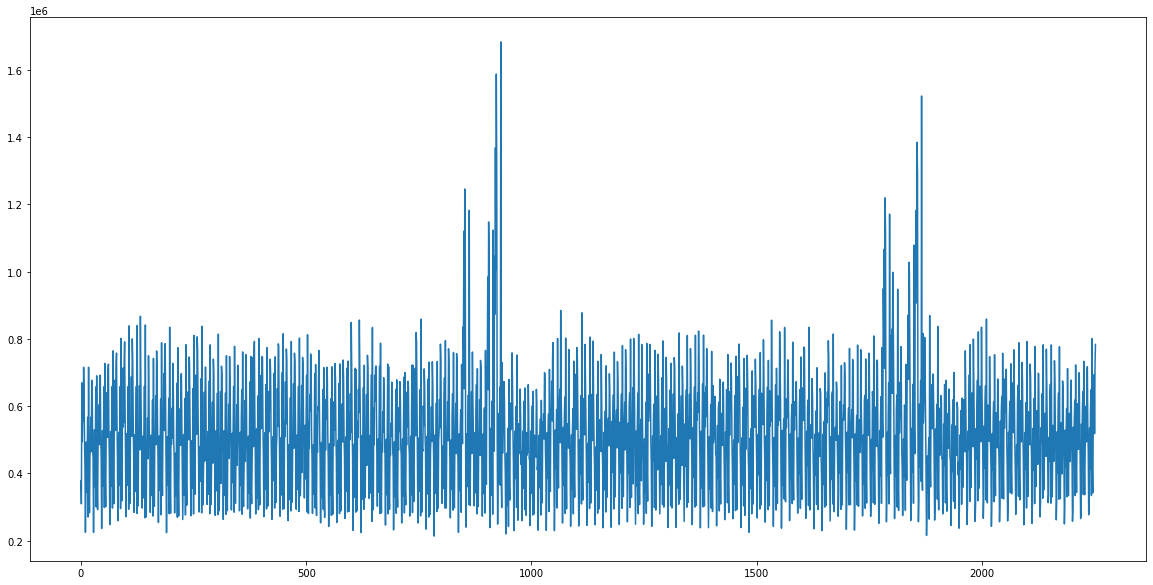

In [87]:
fig = plt.figure(figsize=(20,10))
plt.plot(np.arange(x_train_num), xSeq_train[:,0,0])
plt.plot(np.arange(x_train_num, x_len), xSeq_test[:,0,0])
plt.legend(["train","test"])
plt.title("data")
plt.show()

In [ ]:
modelRNN = tf.keras.Sequential()

modelRNN.add(
    layers.LSTM(
        units=64,
        input_shape=(seqLen, featNum),
        name="rekurencja_pierwsza",
        return_sequences=True
    )
)

modelRNN.add(
    layers.Dropout(0.0)
)

modelRNN.add(
    layers.LSTM(
        units=64,
        name="rekurencja_druga"
    )
)

modelRNN.add(
    layers.Dense(
        units=64,
        activation="relu"
    )
)

modelRNN.add(
    layers.Dropout(0.0)
)

modelRNN.add(
    layers.Dense(
        units=1,
        name="wyjscie"
    )
)

modelRNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rekurencja_pierwsza (LSTM)  (None, 4, 64)             17152     
                                                                 
 dropout_2 (Dropout)         (None, 4, 64)             0         
                                                                 
 rekurencja_druga (LSTM)     (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 wyjscie (Dense)             (None, 1)                 65        
                                                                 
Total params: 54,401
Trainable params: 54,401
Non-trai

In [ ]:
modelRNN.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="mse"
)

In [ ]:
history = modelRNN.fit(
    x=xSeq_train,
    y=y_train,
    epochs=10,
    batch_size=4,
    validation_data=(xSeq_test, y_test),
    
)

Epoch 1/10
634/634 [==============================] - 16s 11ms/step - loss: 290014986240.0000 - val_loss: 268703809536.0000
Epoch 2/10
634/634 [==============================] - 5s 8ms/step - loss: 287128780800.0000 - val_loss: 264645918720.0000
Epoch 3/10
634/634 [==============================] - 5s 7ms/step - loss: 281909821440.0000 - val_loss: 258557444096.0000
Epoch 4/10
634/634 [==============================] - 4s 7ms/step - loss: 274847481856.0000 - val_loss: 250870661120.0000
Epoch 5/10
634/634 [==============================] - 5s 7ms/step - loss: 266300702720.0000 - val_loss: 241870913536.0000
Epoch 6/10
634/634 [==============================] - 5s 8ms/step - loss: 256541704192.0000 - val_loss: 231794049024.0000
Epoch 7/10
634/634 [==============================] - 5s 8ms/step - loss: 245758640128.0000 - val_loss: 220805300224.0000
Epoch 8/10
634/634 [==============================] - 4s 7ms/step - loss: 234134994944.0000 - val_loss: 209097719808.0000
Epoch 9/10
634/634 [==

In [ ]:
y_pred = modelRNN.predict(xSeq_test)

9/9 [==============================] - 0s 6ms/step


In [ ]:
mean_squared_error(y_test,y_pred)

184031356524.10043

In [ ]:
r2_score(y_test,y_pred)

-8.973952047015398

In [ ]:
mean_absolute_percentage_error(y_test,y_pred)

0.7947370664394833

In [ ]:
y_pred

array([[94858.07],
       [94858.07],
       [94858.07],
       [94858.07],
       [94858.07],
       [94858.07],
       [94858.07],
       [94858.07],
       [94858.07],
       [94858.07],
       [94858.07],
       [94858.07],
       [94858.07],
       [94858.07],
       [94858.07],
       [94858.07],
       [94858.07],
       [94858.07],
       [94858.07],
       [94858.07],
       [94858.07],
       [94858.07],
       [94858.07],
       [94858.07],
       [94858.07],
       [94858.07],
       [94858.07],
       [94858.07],
       [94858.07],
       [94858.07],
       [94858.08],
       [94858.08],
       [94858.07],
       [94858.07],
       [94858.07],
       [94858.07],
       [94858.07],
       [94858.07],
       [94858.07],
       [94858.07],
       [94858.07],
       [94858.07],
       [94858.07],
       [94858.07],
       [94858.07],
       [94858.07],
       [94858.07],
       [94858.07],
       [94858.07],
       [94858.07],
       [94858.07],
       [94858.07],
       [9485